# 뉴스 카테고리 다중분류 [프로젝트]

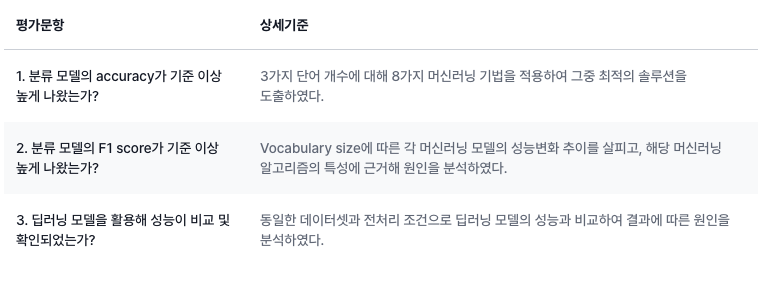

In [1]:
from tensorflow.keras.datasets import reuters
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
from tqdm import tqdm
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
# from sklearn.naive_bayes import MultinomialNB #다항분포 나이브 베이즈 모델
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.naive_bayes import ComplementNB
# from sklearn.tree import DecisionTreeClassifier
# from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import VotingClassifier
# from sklearn.svm import LinearSVC
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, f1_score

2024-12-16 14:48:48.530451: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


## 머신러닝 모델 사용

In [2]:
# 로이터 데이터셋 로드 (모든 단어 사용)
(x_train, y_train), (x_test, y_test) = reuters.load_data(num_words=None, test_split=0.2)

### 데이터 EDA 및 전처리

In [3]:
print('훈련 샘플의 수: {}'.format(len(x_train)))
print('테스트 샘플의 수: {}'.format(len(x_test)))

훈련 샘플의 수: 8982
테스트 샘플의 수: 2246


In [4]:
num_classes = max(y_train) + 1
print('클래스의 수 : {}'.format(num_classes))

클래스의 수 : 46


훈련용 뉴스의 최대 길이 :2376
훈련용 뉴스의 평균 길이 :145.5398574927633


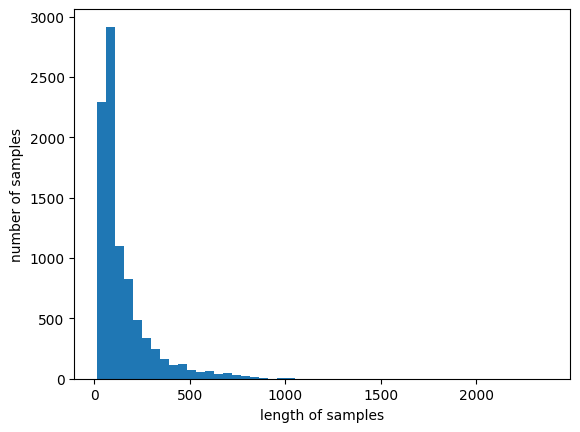

In [5]:
# 데이터 분포 보기
print('훈련용 뉴스의 최대 길이 :{}'.format(max(len(l) for l in x_train)))
print('훈련용 뉴스의 평균 길이 :{}'.format(sum(map(len, x_train))/len(x_train)))

plt.hist([len(s) for s in x_train], bins=50)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

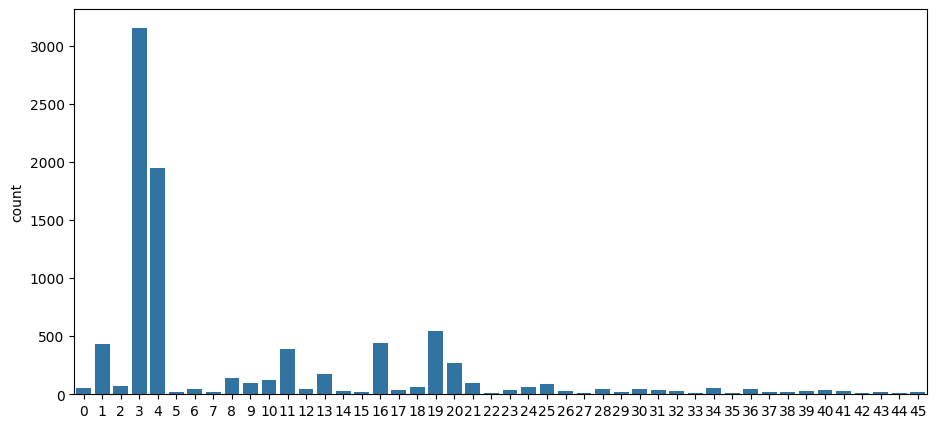

In [6]:
fig, axe = plt.subplots(ncols=1)
fig.set_size_inches(11,5)
sns.countplot(x=y_train)
plt.show()

In [ ]:
unique_elements, counts_elements = np.unique(y_train, return_counts=True)
print("각 클래스 빈도수:")
print(np.asarray((unique_elements, counts_elements)))

각 클래스 빈도수:
[[   0    1    2    3    4    5    6    7    8    9   10   11   12   13
    14   15   16   17   18   19   20   21   22   23   24   25   26   27
    28   29   30   31   32   33   34   35   36   37   38   39   40   41
    42   43   44   45]
 [  55  432   74 3159 1949   17   48   16  139  101  124  390   49  172
    26   20  444   39   66  549  269  100   15   41   62   92   24   15
    48   19   45   39   32   11   50   10   49   19   19   24   36   30
    13   21   12   18]]


In [8]:
word_index = reuters.get_word_index(path="reuters_word_index.json")

이 데이터에는 숨겨진 비밀이 하나 있는데, 뉴스 데이터 안에서 단어 'the'는 사실 1번이 아니라 4번 단어입니다.\
그리고 단어 'it'은 사실 13번 단어가 아니라 16번 단어입니다. 왜냐하면 0번, 1번, 2번은 사실 자연어 처리에 쓰이는 특별한 토큰들을 위해 맵핑된 번호이기 때문입니다.\
(각각 <'pad'>, <'sos'>, <'unk'> 라는 토큰을 나타냅니다.)

In [9]:
index_to_word = { index+3 : word for word, index in word_index.items() }

In [10]:
# index_to_word에 숫자 0은 <pad>, 숫자 1은 <sos>, 숫자 2는 <unk>를 넣어줍니다.
for index, token in enumerate(("<pad>", "<sos>", "<unk>")):
  index_to_word[index]=token

In [11]:
decoded = []
for i in range(len(x_train)):
    t = ' '.join([index_to_word[index] for index in x_train[i]])
    decoded.append(t)
    
x_train = decoded
print(len(x_train))

8982


In [12]:
decoded = []
for i in range(len(x_test)):
  t = ' '.join([index_to_word[index] for index in x_test[i]])
  decoded.append(t)
  
x_test = decoded
print(len(x_test))

2246


In [13]:
dtm_vec = CountVectorizer()
x_train_dtm = dtm_vec.fit_transform(x_train)
print(x_train_dtm.shape)

(8982, 26506)


In [14]:
tfidf_vec = TfidfTransformer()
x_train_tfidf = tfidf_vec.fit_transform(x_train_dtm)
print(x_train_tfidf.shape)

(8982, 26506)


In [15]:
x_test_dtm = dtm_vec.transform(x_test) #테스트 데이터를 DTM으로 변환
x_test_tfidf = tfidf_vec.transform(x_test_dtm) #DTM을 TF-IDF 행렬로 변환

### 머신러닝 모델 사용 
각 모델 별 학습, 정확도, f1 score 계산
- 모델 종류 : 나이브 베이즈 분류기, CNB, 로지스틱 회귀, 서포트 벡터 머신, 결정 트리, 랜덤 포레스트, 그래디언트 부스팅 트리, 보팅
- 사용 모델 : CNB, 로지스틱 회귀, 그래디언트 부스팅 트리, 보팅 

In [16]:
# 모델 정의 : CNB, 로지스틱 회귀, 랜덤 포레스트, 보팅 
cb = ComplementNB()
lr = LogisticRegression(C=10000, penalty='l2', max_iter=3000)
grbt = GradientBoostingClassifier(random_state=0,learning_rate = 0.01, verbose=3)
VotingClassifier = VotingClassifier(estimators = [
    ('lr', lr), ('cb', cb), ('grbt', grbt)], 
    voting = 'soft', n_jobs = -1)


In [17]:
# 성능 평가 함수 정의
def evaluate_models(models, x_train_tfidf, y_train, x_test_tfidf, y_test):
    results = []
    print("\n=== Training Models ===\n")
    for name, model in tqdm(models, desc="Model Training Progress", ncols=80):
        print(f"\nTraining {name}...\n{'-'*50}")
        
        # 모델 학습
        model.fit(x_train_tfidf, y_train)
        
        # 예측
        predicted = model.predict(x_test_tfidf)
        
        # 정확도
        acc = accuracy_score(y_test, predicted)
        
        # Confusion Matrix 및 F1 Score
        conf_matrix = confusion_matrix(y_test, predicted)
        f1 = f1_score(y_test, predicted, average='weighted')
        
        # 결과 저장
        results.append({
            "Model": name,
            "Accuracy": acc,
            "F1 Score": f1,
            "Confusion Matrix": conf_matrix
        })
        
        # 출력
        print(f"\nModel: {name}")
        print(f"Accuracy: {acc:.4f}")
        print(f"F1 Score: {f1:.4f}")
        print(f"Confusion Matrix:\n{conf_matrix}")
        print("\nClassification Report:")
        print(classification_report(y_test, predicted))
        print("="*50)
    
    return results

In [21]:
#모델 리스트
models = [
    ("Complement Naive Bayes", cb),
    ("Logistic Regression", lr),
    ("Gradient Boosting", grbt),
    ("Voting Classifier", VotingClassifier)
]

In [22]:
results = evaluate_models(models, x_train_tfidf, y_train, x_test_tfidf, y_test)


=== Training Models ===



Model Training Progress:   0%|                            | 0/4 [00:00<?, ?it/s]


Training Complement Naive Bayes...
--------------------------------------------------

Model: Complement Naive Bayes
Accuracy: 0.7649
F1 Score: 0.7347
Confusion Matrix:
[[ 6  3  0 ...  0  0  0]
 [ 0 92  0 ...  0  0  0]
 [ 0  4 10 ...  0  0  0]
 ...
 [ 0  0  0 ...  1  0  0]
 [ 0  1  0 ...  0  4  0]
 [ 0  0  0 ...  0  0  1]]

Classification Report:
              precision    recall  f1-score   support

           0       0.86      0.50      0.63        12
           1       0.63      0.88      0.73       105
           2       0.91      0.50      0.65        20
           3       0.87      0.91      0.89       813
           4       0.75      0.93      0.83       474
           5       0.00      0.00      0.00         5
           6       0.92      0.86      0.89        14
           7       1.00      0.67      0.80         3
           8       0.43      0.08      0.13        38
           9       0.81      0.88      0.85        25
          10       0.96      0.73      0.83        30
 

/home/mjun/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/mjun/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/mjun/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Model Training Progress:  50%|█████████▌      


Model: Logistic Regression
Accuracy: 0.8170
F1 Score: 0.8118
Confusion Matrix:
[[ 8  1  0 ...  0  0  0]
 [ 0 83  1 ...  0  0  0]
 [ 0  0 14 ...  0  0  0]
 ...
 [ 0  0  0 ...  6  0  0]
 [ 0  1  0 ...  0  4  0]
 [ 0  0  0 ...  0  0  1]]

Classification Report:
              precision    recall  f1-score   support

           0       0.89      0.67      0.76        12
           1       0.74      0.79      0.76       105
           2       0.78      0.70      0.74        20
           3       0.92      0.93      0.93       813
           4       0.81      0.88      0.84       474
           5       1.00      0.20      0.33         5
           6       0.93      0.93      0.93        14
           7       1.00      0.33      0.50         3
           8       0.71      0.71      0.71        38
           9       0.85      0.88      0.86        25
          10       0.93      0.90      0.92        30
          11       0.67      0.72      0.70        83
          12       0.57      0.31    

/home/mjun/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/mjun/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/mjun/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Model Training Progress:  75%|██████████████▎ 


Model: Gradient Boosting
Accuracy: 0.7596
F1 Score: 0.7455
Confusion Matrix:
[[ 8  0  0 ...  0  0  0]
 [ 0 72  1 ...  0  0  0]
 [ 0  0 12 ...  0  0  0]
 ...
 [ 0  0  0 ...  3  0  0]
 [ 0  1  0 ...  0  4  0]
 [ 0  0  0 ...  0  0  1]]

Classification Report:
              precision    recall  f1-score   support

           0       0.89      0.67      0.76        12
           1       0.82      0.69      0.75       105
           2       0.63      0.60      0.62        20
           3       0.78      0.91      0.84       813
           4       0.76      0.86      0.81       474
           5       0.00      0.00      0.00         5
           6       0.85      0.79      0.81        14
           7       1.00      0.33      0.50         3
           8       0.67      0.58      0.62        38
           9       0.92      0.88      0.90        25
          10       0.83      0.83      0.83        30
          11       0.65      0.63      0.64        83
          12       0.78      0.54      

/home/mjun/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/mjun/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/mjun/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Model Training Progress: 100%|████████████████


Model: Voting Classifier
Accuracy: 0.8264
F1 Score: 0.8199
Confusion Matrix:
[[ 8  1  0 ...  0  0  0]
 [ 0 85  1 ...  0  0  0]
 [ 0  0 16 ...  0  0  0]
 ...
 [ 0  0  0 ...  6  0  0]
 [ 0  1  0 ...  0  4  0]
 [ 0  0  0 ...  0  0  1]]

Classification Report:
              precision    recall  f1-score   support

           0       0.89      0.67      0.76        12
           1       0.77      0.81      0.79       105
           2       0.80      0.80      0.80        20
           3       0.92      0.95      0.93       813
           4       0.82      0.88      0.85       474
           5       0.00      0.00      0.00         5
           6       0.93      0.93      0.93        14
           7       1.00      0.33      0.50         3
           8       0.68      0.71      0.69        38
           9       0.85      0.88      0.86        25
          10       0.90      0.90      0.90        30
          11       0.69      0.73      0.71        83
          12       0.60      0.46      

In [31]:
# # 결과 요약 - data frame으로 변환
# "Model" : "Complement Naive Bayes", "Accuracy" : 0.7649, "F1 Score": 0.7347
# "Model" : "Logistic Regression", "Accuracy" : 0.8170, "F1 Score": 0.8118
# "Model" : "Gradient Boosting", "Accuracy" : 0.7596, "F1 Score": 0.7455
# "Model" : "Voting Classifier", "Accuracy" : 0.8264, "F1 Score": 0.8199

# 주석 정보를 데이터프레임으로 변환
ml_results = {
    "Model": ["Complement Naive Bayes", "Logistic Regression", "Gradient Boosting", "Voting Classifier"],
    "Accuracy": [0.7649, 0.8170, 0.7596, 0.8264],
    "F1 Score": [0.7347, 0.8118, 0.7455, 0.8199]
}

summary = pd.DataFrame(ml_results)


### 결과 시각화 - 머신러닝 모델

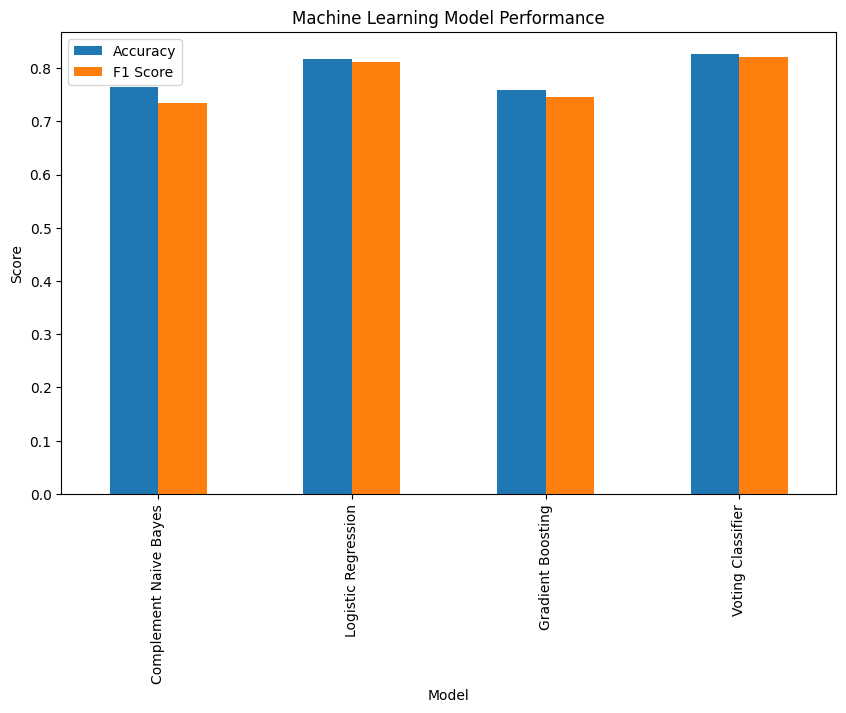

In [32]:
summary.set_index('Model', inplace=True)
summary.plot(kind='bar', figsize=(10, 6))
plt.title("Machine Learning Model Performance")
plt.xlabel("Model")
plt.ylabel("Score")
plt.show()

## 딥러닝 모델 사용 - RNN - LSTM

### 데이터 분포 확인 - max len 정하기

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


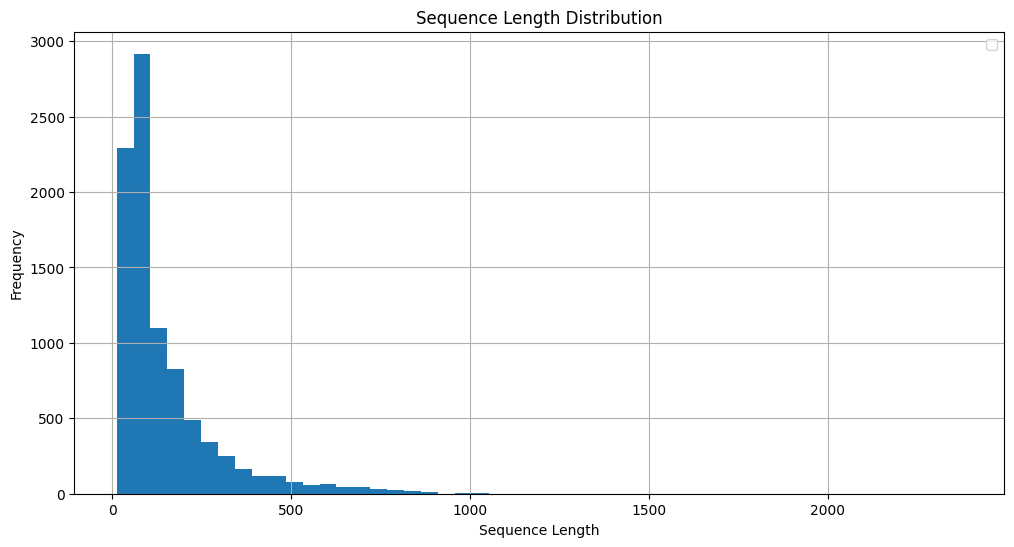

In [ ]:
# 데이터 로드 및 전처리
max_words = None  # 사용할 최대 단어 수
word_index = reuters.get_word_index()
vocab_size = len(word_index) + 1

# 로이터 데이터셋 재로드
(x_train, y_train), (x_test, y_test) = reuters.load_data(num_words=max_words, test_split=0.2)

# 샘플의 길이 계산
train_seq_lengths = [len(seq) for seq in x_train]

# 전체 데이터 길이 분포 시각화
plt.figure(figsize=(12, 6))
plt.hist(train_seq_lengths, bins=50)
plt.title("Sequence Length Distribution")
plt.xlabel("Sequence Length")
plt.ylabel("Frequency")
plt.legend()
plt.grid(True)
plt.show()

In [53]:
# 데이터 분포 기준으로 max_len 결정
percentile = 95  
max_len = int(np.percentile(train_seq_lengths, percentile))

print(f"학습 데이터 기준 95% 이상의 데이터를 커버하기 위한 max_len: {max_len}")

학습 데이터 기준 95% 이상의 데이터를 커버하기 위한 max_len: 459


In [54]:
from keras.models import Sequential
from keras.layers import Embedding, LSTM, Dense, Dropout
from keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical

In [55]:
# 시퀀스 패딩 처리
x_train = pad_sequences(x_train, maxlen=max_len)
x_test = pad_sequences(x_test, maxlen=max_len)

# 레이블을 원-핫 인코딩
num_classes = np.max(y_train) + 1
y_train = to_categorical(y_train, num_classes)
y_test = to_categorical(y_test, num_classes)

### 모델 정의 및 학습

In [ ]:
# RNN-LSTM 모델 정의
model = Sequential([
    Embedding(input_dim = vocab_size, output_dim = 128, input_length=max_len),  # 임베딩 층
    LSTM(64, return_sequences=False),  # LSTM 층
    Dropout(0.5),
    Dense(128, activation='relu'),  # 완전 연결 층
    Dropout(0.5),
    Dense(num_classes, activation='softmax')  # 출력층
])

2024-12-16 12:23:00.095078: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1639] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 9621 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 2080 Ti, pci bus id: 0000:19:00.0, compute capability: 7.5
2024-12-16 12:23:00.096470: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1639] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 9621 MB memory:  -> device: 1, name: NVIDIA GeForce RTX 2080 Ti, pci bus id: 0000:1a:00.0, compute capability: 7.5
2024-12-16 12:23:00.097039: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1639] Created device /job:localhost/replica:0/task:0/device:GPU:2 with 9621 MB memory:  -> device: 2, name: NVIDIA GeForce RTX 2080 Ti, pci bus id: 0000:67:00.0, compute capability: 7.5
2024-12-16 12:23:00.097595: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1639] Created device /job:localhost/replica:0/task:0/device:GPU:3 with 9604 MB memory:  -> device: 3, name: NVIDIA GeForce RTX

In [57]:
# 모델 컴파일
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [58]:
# 모델 학습
from keras.callbacks import EarlyStopping
early_stop = EarlyStopping(monitor='val_loss', patience=3, verbose=1)

batch_size = 64
epochs = 10
history = model.fit(
    x_train, 
    y_train, 
    validation_split=0.2, 
    epochs=epochs, 
    batch_size=batch_size, 
    verbose=1,
    callbacks=[early_stop]
)


Epoch 1/10


2024-12-16 12:24:41.827301: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:432] Loaded cuDNN version 8801
2024-12-16 12:24:42.771732: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x7fdf30027e10 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2024-12-16 12:24:42.771772: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA GeForce RTX 2080 Ti, Compute Capability 7.5
2024-12-16 12:24:42.771781: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (1): NVIDIA GeForce RTX 2080 Ti, Compute Capability 7.5
2024-12-16 12:24:42.771789: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (2): NVIDIA GeForce RTX 2080 Ti, Compute Capability 7.5
2024-12-16 12:24:42.771796: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (3): NVIDIA GeForce RTX 2080 Ti, Compute Capability 7.5
2024-12-16 12:24:42.777522: I tensorflow/compiler/mlir/te

113/113 [==============================] - 39s 293ms/step - loss: 2.6608 - accuracy: 0.3226 - val_loss: 2.0088 - val_accuracy: 0.3812
Epoch 2/10
113/113 [==============================] - 30s 268ms/step - loss: 1.8298 - accuracy: 0.5187 - val_loss: 1.6883 - val_accuracy: 0.5565
Epoch 3/10
113/113 [==============================] - 28s 247ms/step - loss: 1.7344 - accuracy: 0.5225 - val_loss: 1.7252 - val_accuracy: 0.5671
Epoch 4/10
113/113 [==============================] - 24s 207ms/step - loss: 1.5967 - accuracy: 0.5549 - val_loss: 1.6579 - val_accuracy: 0.5693
Epoch 5/10
113/113 [==============================] - 18s 160ms/step - loss: 1.4900 - accuracy: 0.5869 - val_loss: 1.7287 - val_accuracy: 0.5838
Epoch 6/10
113/113 [==============================] - 20s 180ms/step - loss: 1.3756 - accuracy: 0.6100 - val_loss: 1.6915 - val_accuracy: 0.5698
Epoch 7/10
113/113 [==============================] - 17s 150ms/step - loss: 1.2769 - accuracy: 0.6341 - val_loss: 1.7179 - val_accuracy: 0.5

In [59]:
# 테스트 데이터 성능 평가
y_pred = model.predict(x_test)
y_pred_classes = np.argmax(y_pred, axis=1)
y_test_classes = np.argmax(y_test, axis=1)

71/71 [==============================] - 1s 9ms/step


In [60]:
# 정확도 및 F1 Score 계산
accuracy = accuracy_score(y_test_classes, y_pred_classes)
f1 = f1_score(y_test_classes, y_pred_classes, average="weighted")

In [61]:
# 출력
print(f"Test Accuracy: {accuracy:.4f}")
print(f"Test F1 Score: {f1:.4f}")
print("\nClassification Report:")
print(classification_report(y_test_classes, y_pred_classes))

Test Accuracy: 0.5833
Test F1 Score: 0.5364

Classification Report:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        12
           1       0.18      0.68      0.29       105
           2       0.00      0.00      0.00        20
           3       0.87      0.92      0.89       813
           4       0.79      0.81      0.80       474
           5       0.00      0.00      0.00         5
           6       0.00      0.00      0.00        14
           7       0.00      0.00      0.00         3
           8       0.00      0.00      0.00        38
           9       0.10      0.44      0.16        25
          10       0.05      0.07      0.06        30
          11       0.00      0.00      0.00        83
          12       0.00      0.00      0.00        13
          13       0.00      0.00      0.00        37
          14       0.00      0.00      0.00         2
          15       0.00      0.00      0.00         9
          16 

/home/mjun/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/mjun/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/mjun/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


### 결과 요약 - ml vs dl 

In [62]:
summary

,Accuracy,F1 Score
Model,,
Complement Naive Bayes,0.7649,0.7347
Logistic Regression,0.8170,0.8118
Gradient Boosting,0.7596,0.7455
Voting Classifier,0.8264,0.8199


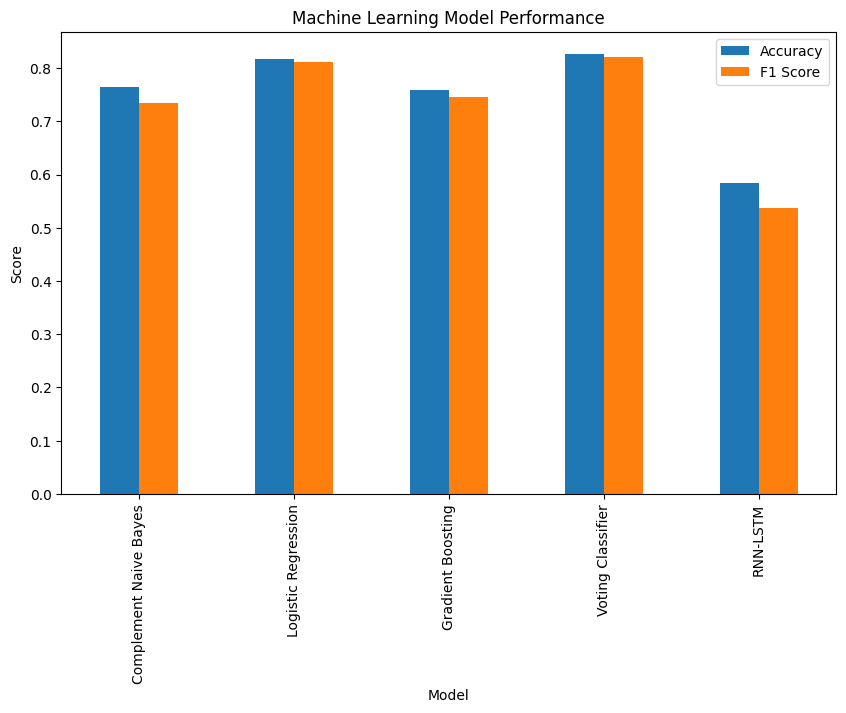

In [63]:
# summary에 rnn 결과 추가
summary.loc["RNN-LSTM"] = [accuracy, f1]
summary.plot(kind='bar', figsize=(10, 6))
plt.title("Machine Learning Model Performance")
plt.xlabel("Model")
plt.ylabel("Score")
plt.show()

## 회고

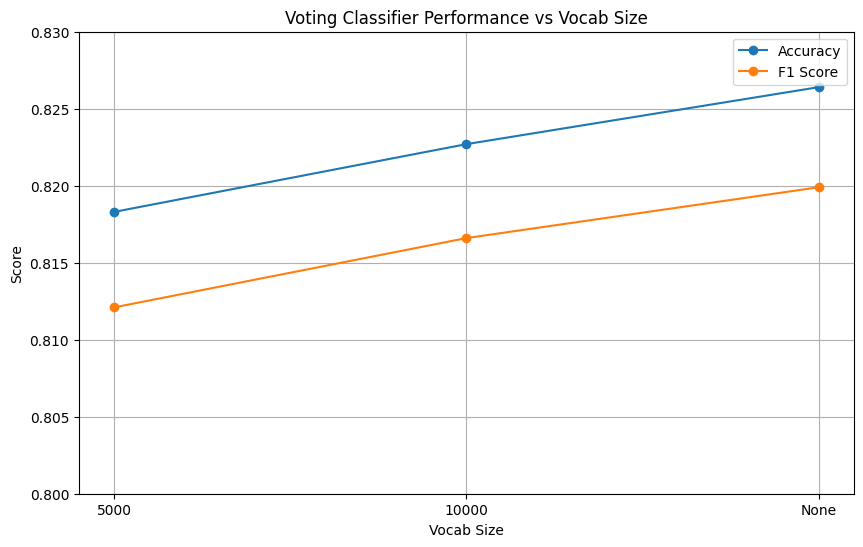

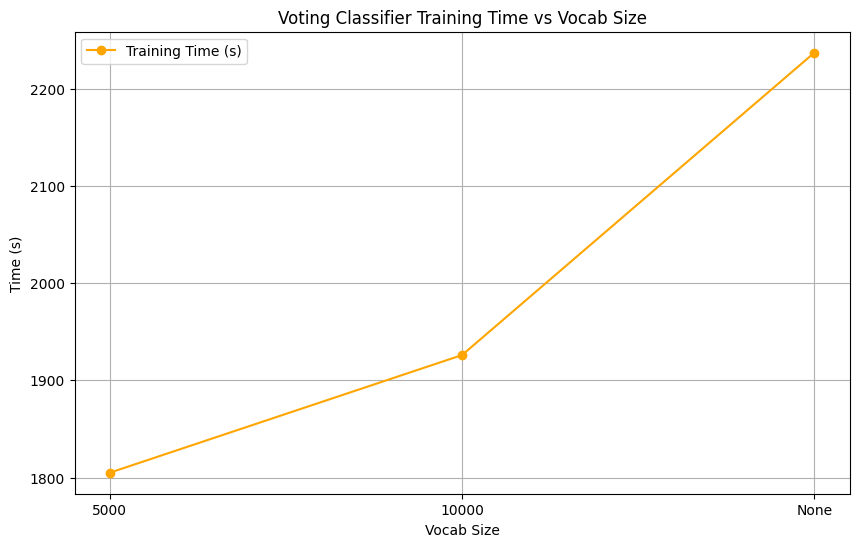

In [24]:
# # Voting Classifier 데이터 정리
# data = {
#     "Vocab_size": ["5000", "10000", "None"],  # 순서를 변경하고 문자열로 통일
#     "Accuracy": [0.8183, 0.8227, 0.8264],
#     "F1 Score": [0.8121, 0.8166, 0.8199],
#     "Time (s)": [30*60 + 5, 32*60 + 6, 37*60 + 17]  # 시간을 초 단위로 변환
# }

# df_voting = pd.DataFrame(data)

# # 그래프 생성
# plt.figure(figsize=(10, 6))

# # Accuracy와 F1 Score 그래프
# plt.plot(df_voting["Vocab_size"], df_voting["Accuracy"], marker='o', label="Accuracy")
# plt.plot(df_voting["Vocab_size"], df_voting["F1 Score"], marker='o', label="F1 Score")

# # 제목 및 레이블 설정
# plt.title("Voting Classifier Performance vs Vocab Size")
# plt.xlabel("Vocab Size")
# plt.ylabel("Score")
# plt.ylim(0.8, 0.83)
# plt.legend()
# plt.grid(True)
# plt.show()

# # 시간 그래프 추가
# plt.figure(figsize=(10, 6))
# plt.plot(df_voting["Vocab_size"], df_voting["Time (s)"], marker='o', color='orange', label="Training Time (s)")

# # 제목 및 레이블 설정
# plt.title("Voting Classifier Training Time vs Vocab Size")
# plt.xlabel("Vocab Size")
# plt.ylabel("Time (s)")
# plt.legend()
# plt.grid(True)
# plt.show()

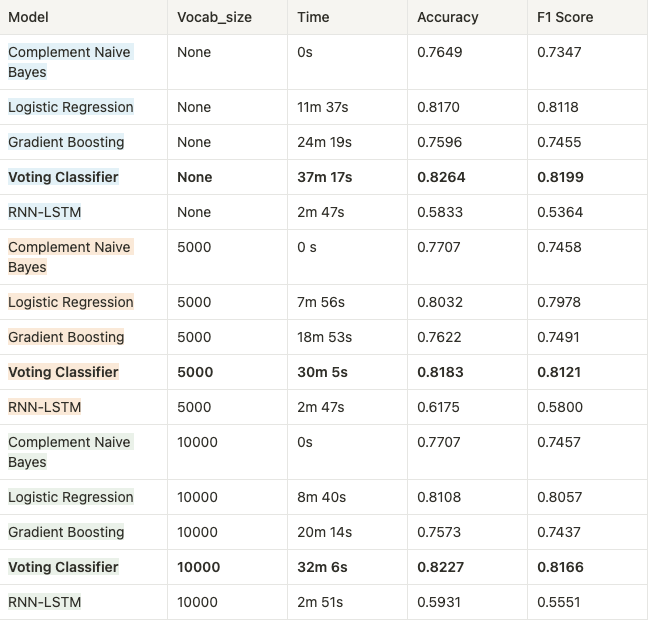

1. vocab size에 따른 학습 시간 상승(5000, 10000, None 순), accuracy, F1 score 증가(전체적인 모델, Voting Classifier)
2. 생각보다 Logistic Regression의 성능이 좋다?
   1. 벡터화가 fit 한가?
   2. 가성비가 좋다
3. 딥러닝의 성능이 좋지않다 왜?
   1. 학습 데이터 크기?
   2. 전처리?
   3. 모델 구조?
      1. Bi-LSTM? 추후에..
      2. 1D-CNN? 추후에..